<a href="https://colab.research.google.com/github/aedenj/continuous-improvement/blob/main/classes/eep-596-llms/project-one/part-two/AedenJameson_MiniProjectOne_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assignment aims to introduce students to working with the BEIR dataset for information retrieval tasks. Students will:

- Understand the structure of the BEIR dataset and preprocess the data.
- Implement a system to encode queries and documents using embeddings.
- Calculate similarity scores to rank documents based on relevance.
- Evaluate the system's performance using metrics like Mean Average Precision (MAP).
- Modify and fine-tune models for better retrieval results.

First start by looking into the Dataset and understanding its structure.
This will help you understand how the dataset is formed, which will be useful in the later stages of the Assignment

https://huggingface.co/datasets/BeIR/nfcorpus

https://huggingface.co/datasets/BeIR/nfcorpus-qrels

This assignment consists of two key tasks: Ranking Documents and Fine-Tuning the Sentence Transformer Model.
Students will be graded based on their implementation and their written report.

Mention the team/Individual contributions as a part of the report..!!

Ranking Documents Report (10 Points)

Students must analyze which encoding methods performed best for document ranking.

What to include in your report:
    
#Comparison of Encoding Methods

Compare GloVe embeddings vs. Sentence Transformer embeddings.
Which method ranked documents better?
Did the top-ranked documents make sense?
How does cosine similarity behave with different embeddings?

#Observations on Cosine Similarity & Ranking

Did the ranking appear meaningful?
Were there cases where documents that should be highly ranked were not?
What are possible explanations for incorrect rankings?

#Possible Improvements

What can be done to improve document ranking?
Would a different distance metric (e.g., Euclidean, Manhattan) help?
Would preprocessing the queries or documents (e.g., removing stopwords) improve ranking?


Fine-Tuning Report (15 Points)

After fine-tuning, students must compare different training approaches and reflect on their findings.

What to include in your report:
    
#Comparison of Different Training Strategies

[anchor, positive] vs [anchor, positive, negative].
Which approach seemed to improve ranking?
How did the model behave differently?

#Impact on MAP Score

Did fine-tuning improve or hurt the Mean Average Precision (MAP) score?
If MAP decreased, why might that be?
Is fine-tuning always necessary for retrieval models?

#Observations on Training Loss & Learning Rate

Did the loss converge?
Was the learning rate too high or too low?
How did freezing/unfreezing layers impact training?

#Future Improvements

Would training with more negatives help?
Would changing the loss function (e.g., using Softmax Loss) improve performance?
Could increasing the number of epochs lead to a better model?


In [1]:
!pip install datasets sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Explore Beir

In [2]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

corpus_name = "BeIR/nfcorpus"

In [3]:
# Create your API token from your Hugging Face Account. Make sure to save it in text file or notepad for future use.
# Will need to add it once per section
from huggingface_hub import login
login()

In [4]:
corpus = load_dataset(corpus_name, "corpus")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

nfcorpus.py:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.20M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/3633 [00:00<?, ? examples/s]

In [5]:
print(corpus)
print(corpus['corpus'][113])

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 3633
    })
})
{'_id': 'MED-878', 'title': 'Acute effects of coffee on endothelial function in healthy subjects.', 'text': 'BACKGROUND/OBJECTIVES: Coffee is the most widely consumed beverage in the world, but its effect on the cardiovascular system has not been fully understood. Coffee contains caffeine and antioxidants, which may influence endothelial function, both of which have not yet been investigated. The objective of this study was to investigate the acute effects of coffee on endothelial function measured by brachial artery flow-mediated dilation (FMD). SUBJECTS/METHODS: A total of 20 (10 males and 10 females) healthy non-obese subjects underwent a double-blind, crossover study. Subjects ingested one cup of caffeinated (CC) and one cup of decaffeinated (DC) Italian espresso coffee in random order at 5- to 7-day intervals. RESULTS: Following CC ingestion, FMD decreased progressively

### Raw Metric on Corpus

In [6]:
corpus_df = corpus['corpus'].to_pandas()

def plot_metrics(data, col, title = '', xlabel = ''):
    """Plot metrics with a histogram."""
    fig, ax = plt.subplots(figsize = (15, 5))
    g = sns.histplot(x = col, data = data)
    g.set(title = title, xlabel = xlabel, ylabel = 'Count');

In [7]:
vectorizer = CountVectorizer(stop_words="english")  # adjust parameters as needed
doc_term_matrix = vectorizer.fit_transform(corpus['corpus']['text'])

print("Shape of our DTM:", doc_term_matrix.shape)

Shape of our DTM: (3633, 25740)


In [8]:
dtm = pd.DataFrame(
    doc_term_matrix.toarray(),
    columns = vectorizer.get_feature_names_out()
)

### Token Count / Text

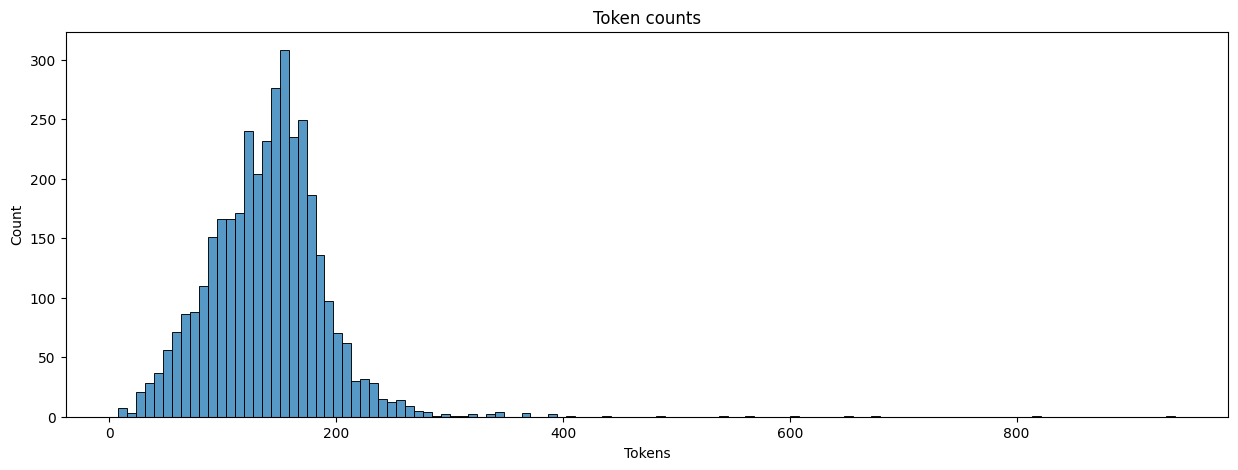

In [9]:
corpus_df.loc[:, 'num_tokens'] = dtm.apply(sum, axis = 1).values
plot_metrics(corpus_df, 'num_tokens', title = 'Token counts', xlabel = 'Tokens')

### Unique Words / Text

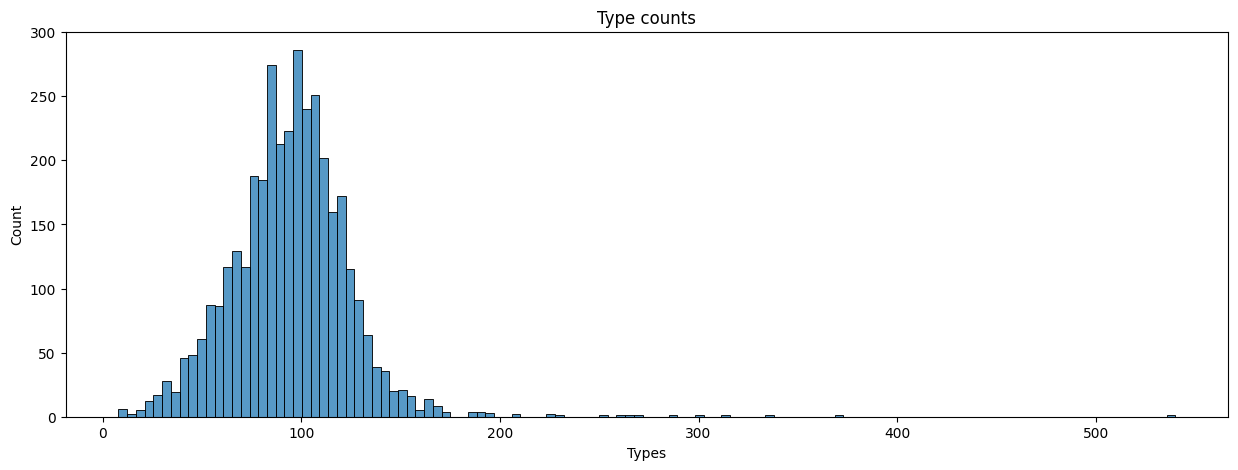

In [10]:
corpus_df.loc[:, 'num_types'] = dtm.apply(np.count_nonzero, axis = 1).values
plot_metrics(corpus_df, 'num_types', title = 'Type counts', xlabel = 'Types')

### Type-Token Ratio

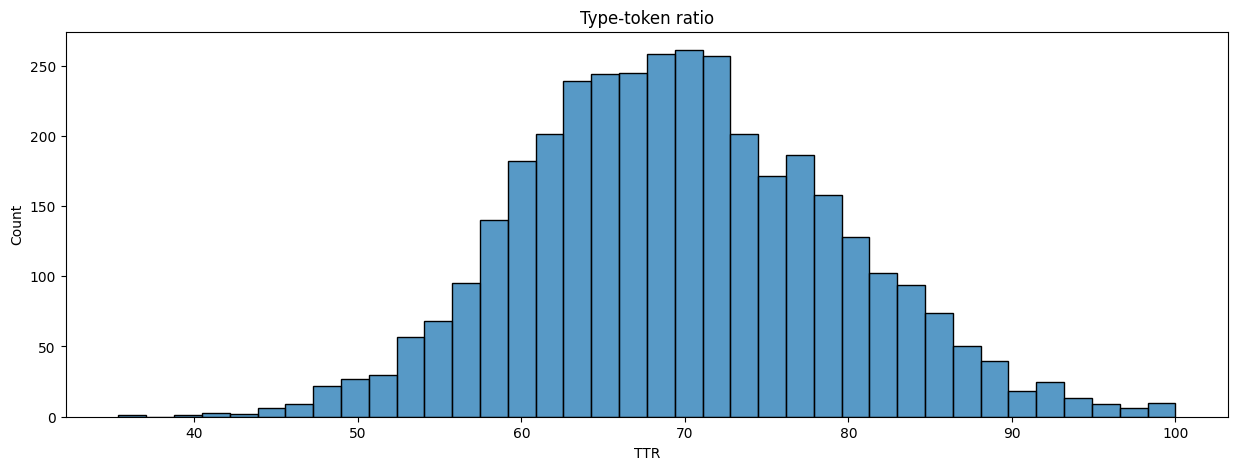

In [11]:
corpus_df.loc[:, 'TTR'] = (corpus_df['num_types'] / corpus_df['num_tokens']) * 100
plot_metrics(corpus_df, 'TTR', title = 'Type-token ratio', xlabel = 'TTR')

### Protypical Examples

Examples of texts that typify the low, medium, and high range of the metrics above.

In [12]:
def show_examples(data, metric, labels = ['low', 'medium', 'high']):
    cuts = pd.qcut(data[metric], len(labels), labels = labels)
    for label in labels:
        idxes = cuts[cuts==label].index
        ex = data[data.index.isin(idxes)].sample()
        print(f"+ {label}: {ex['title'].item()} ({ex[metric].item():0.2f})")

for metric in ('num_tokens', 'num_types', 'TTR'):
    print("Examples for", metric)
    show_examples(corpus_df, metric)
    print("\n")

Examples for num_tokens
+ low: Human exposure to endocrine disrupters: carcinogenic risk assessment. (109.00)
+ medium: Prevalence of potentially neuropathic Campylobacter jejuni strains on commercial broiler chicken products. (137.00)
+ high: Bulking agents, antispasmodics and antidepressants for the treatment of irritable bowel syndrome. (488.00)


Examples for num_types
+ low: Influence of tart cherry juice on indices of recovery following marathon running. (84.00)
+ medium: The postprandial effect of components of the Mediterranean diet on endothelial function. (98.00)
+ high: Cod liver oil intake and incidence of asthma in Norwegian adults--the HUNT study. (110.00)


Examples for TTR
+ low: Serum enterolactone and prognosis of postmenopausal breast cancer. (65.08)
+ medium: Does having a drink help you think? 6-7-Year-old children show improvements in cognitive performance from baseline to test after having a drink of ... (72.88)
+ high: Excretion, isolation and structure of a new

### Most Common Terms

In [13]:
summed = pd.DataFrame(dtm.sum(), columns = ('count', ))
summed.sort_values('count', ascending = False, inplace = True)
summed.head(5)

,count
risk,3343
cancer,2666
study,2660
intake,2468
diet,2258


### Least Common Terms

In [14]:
summed.tail(5)

,count
0050045,1
0051,1
0058,1
élevés,1
épidémiologique,1


In [15]:
hapaxes = summed[summed['count'] == 1]
print(f"{len(hapaxes)} hapaxes ({len(hapaxes) / len(dtm.T) * 100:0.2f}%)")

9197 hapaxes (35.73%)


### Term Distribution

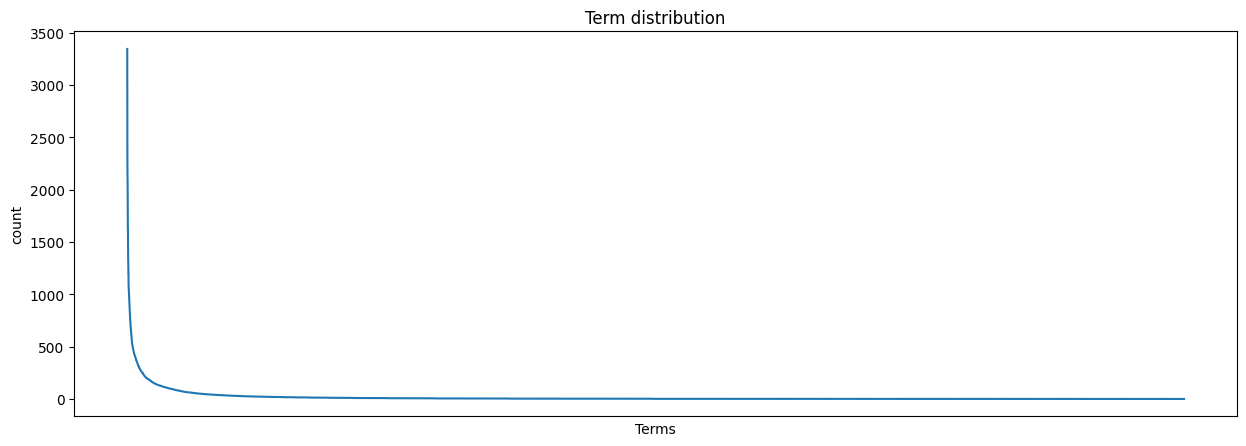

In [16]:
fig, ax = plt.subplots(figsize = (15, 5))
g = sns.lineplot(x = summed.index, y = 'count', data = summed)
g.set(title = 'Term distribution', xlabel = 'Terms', xticks = []);

## Implement Model

In [17]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-02-08 23:07:26--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-08 23:07:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.34MB/s    in 3m 24s  

2025-02-08 23:10:51 (4.03 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [55]:
import torch
import random
from torch.utils.data import DataLoader
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, InformationRetrievalEvaluator


class TextSimilarityModel:
    def __init__(self, corpus_name, rel_name, model_name='all-MiniLM-L6-v2', top_k=10):
        """
        Initialize the model with datasets and pre-trained sentence transformer.
        """
        self.model = SentenceTransformer(model_name)
        self.corpus_name = corpus_name
        self.rel_name = rel_name
        self.top_k = top_k
        self.load_data()
        self.glove_embeddings = {}
        self.with_negatives = False

    def load_data(self):
        """
        Load and filter datasets based on test queries and documents.
        """
        # Load query and document datasets
        dataset_queries = load_dataset(self.corpus_name, "queries")
        dataset_docs = load_dataset(self.corpus_name, "corpus")

        # Extract queries and documents
        self.queries = dataset_queries["queries"]["text"]
        self.query_ids = dataset_queries["queries"]["_id"]
        self.documents = dataset_docs["corpus"]["text"]
        self.document_ids = dataset_docs["corpus"]["_id"]


        # Filter queries and documents and build relevant queries and documents mapping based on test set
        test_qrels = load_dataset(self.rel_name)["test"]
        self.filtered_test_query_ids = set(test_qrels["query-id"])
        self.filtered_test_doc_ids = set(test_qrels["corpus-id"])

        self.test_queries = [q for qid, q in zip(self.query_ids, self.queries) if qid in self.filtered_test_query_ids]
        self.test_query_ids = [qid for qid in self.query_ids if qid in self.filtered_test_query_ids]
        self.test_documents = [doc for did, doc in zip(self.document_ids, self.documents) if did in self.filtered_test_doc_ids]
        self.test_document_ids = [did for did in self.document_ids if did in self.filtered_test_doc_ids]

        self.test_query_id_to_relevant_doc_ids = {qid: [] for qid in self.test_query_ids}
        for qid, doc_id in zip(test_qrels["query-id"], test_qrels["corpus-id"]):
            if qid in self.test_query_id_to_relevant_doc_ids:
                self.test_query_id_to_relevant_doc_ids[qid].append(doc_id)

        ## Code Below this is used for creating the training set
        # Build query and document id to text mapping
        self.query_id_to_text = {query_id:query for query_id, query in zip(self.query_ids, self.queries)}
        self.document_id_to_text = {document_id:document for document_id, document in zip(self.document_ids, self.documents)}

        # Build relevant queries and documents mapping based on train set
        train_qrels = load_dataset(self.rel_name)["train"]
        self.filtered_train_query_ids = set(train_qrels["query-id"])
        self.filtered_train_doc_ids = set(train_qrels["corpus-id"])
        self.train_query_id_to_relevant_doc_ids = {qid: [] for qid in train_qrels["query-id"]}

        for qid, doc_id in zip(train_qrels["query-id"], train_qrels["corpus-id"]):
            if qid in self.train_query_id_to_relevant_doc_ids:
                # Append the document ID to the relevant doc mapping
                self.train_query_id_to_relevant_doc_ids[qid].append(doc_id)

        # Filter queries and documents and build relevant queries and documents mapping based on validation set
        #TODO Put your code here.
         ###########################################################################
        self.valid_qrels = load_dataset(self.rel_name)["validation"]
        self.valid_query_id_to_relevant_doc_ids = {qid: [] for qid in self.valid_qrels["query-id"]}

        for qid, doc_id in zip(self.valid_qrels["query-id"], self.valid_qrels["corpus-id"]):
            if qid in self.valid_query_id_to_relevant_doc_ids:
                # Append the document ID to the relevant doc mapping
                self.valid_query_id_to_relevant_doc_ids[qid].append(doc_id)

        ###########################################################################


    #Task 1: Encode Queries and Documents (10 Pts)

    def encode_with_glove(self, glove_file_path: str, sentences: list[str]) -> list[np.ndarray]:

        """
        # Inputs:
            - glove_file_path (str): Path to the GloVe embeddings file (e.g., "glove.6B.50d.txt").
            - sentences (list[str]): A list of sentences to encode.

        # Output:
            - list[np.ndarray]: A list of sentence embeddings

        (1) Encodes sentences by averaging GloVe 50d vectors of words in each sentence.
        (2) Return a sequence of embeddings of the sentences.
        Download the glove vectors from here.
        https://nlp.stanford.edu/data/glove.6B.zip
        Handle unknown words by using zero vectors
        """
        #TODO Put your code here.
        ###########################################################################
        self.glove_embeddings = {}
        with open(glove_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.strip().split()
                word = values[0]

                vector = np.array(values[1:], dtype='float32')
                self.glove_embeddings[word] = vector


        model_dim = int(glove_file_path.split(".")[2].replace('d', ''))
        sentence_embeddings = []
        for s in sentences:
          words = re.findall(r"\w+", s)

          embedding = np.zeros(model_dim)
          for w in words:
            word_embedding = self.glove_embeddings.get(w, np.zeros(model_dim))
            embedding += word_embedding

          sentence_embeddings.append(embedding / len(words))

        return sentence_embeddings
        ###########################################################################

    #Task 2: Calculate Cosine Similarity and Rank Documents (20 Pts)

    def rank_documents(self, encoding_method: str = 'sentence_transformer') -> None:
        """
         # Inputs:
            - encoding_method (str): The method used for encoding queries/documents.
                             Options: ['glove', 'sentence_transformer'].

        # Output:
            - None (updates self.query_id_to_ranked_doc_ids with ranked document IDs).

        (1) Compute cosine similarity between each document and the query
        (2) Rank documents for each query and save the results in a dictionary "query_id_to_ranked_doc_ids"
            This will be used in "mean_average_precision"
            Example format {2: [125, 673], 35: [900, 822]}
        """
        if encoding_method == 'glove':
            query_embeddings = self.encode_with_glove("glove.6B.50d.txt", self.queries)
            document_embeddings = self.encode_with_glove("glove.6B.50d.txt", self.documents)
        elif encoding_method == 'sentence_transformer':
            query_embeddings = self.model.encode(self.queries)
            document_embeddings = self.model.encode(self.documents)
        else:
            raise ValueError("Invalid encoding method. Choose 'glove' or 'sentence_transformer'.")


        #TODO Put your code here.
        ###########################################################################
         # define a dictionary to store the ranked documents for each query
        self.query_id_to_ranked_doc_ids = {}

        similarities = cosine_similarity(query_embeddings, document_embeddings)
        for i, q_id in enumerate(self.query_ids):
            indexed_scores = list(enumerate(similarities[i]))
            sorted_scores = sorted(indexed_scores, key=lambda x: x[1], reverse=True)
            self.query_id_to_ranked_doc_ids[q_id] = [self.document_ids[id] for id, _ in sorted_scores]
        ###########################################################################

    @staticmethod
    def average_precision(relevant_docs: list[str], candidate_docs: list[str]) -> float:
        """
        # Inputs:
            - relevant_docs (list[str]): A list of document IDs that are relevant to the query.
            - candidate_docs (list[str]): A list of document IDs ranked by the model.

        # Output:
            - float: The average precision score

        Compute average precision for a single query.
        """
        y_true = [1 if doc_id in relevant_docs else 0 for doc_id in candidate_docs]
        precisions = [np.mean(y_true[:k+1]) for k in range(len(y_true)) if y_true[k]]
        return np.mean(precisions) if precisions else 0

    #Task 3: Calculate Evaluate System Performance (10 Pts)

    def mean_average_precision(self) -> float:
        """
        # Inputs:
            - None (uses ranked documents stored in self.query_id_to_ranked_doc_ids).

        # Output:
            - float: The MAP score, computed as the mean of all average precision scores.

        (1) Compute mean average precision for all queries using the "average_precision" function.
        (2) Compute the mean of all average precision scores
        Return the mean average precision score

        reference: https://www.evidentlyai.com/ranking-metrics/mean-average-precision-map
        https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2
        """
         #TODO Put your code here.
        ###########################################################################
        total = 0
        for id in self.test_query_ids:
            total += self.average_precision(
                    self.test_query_id_to_relevant_doc_ids[id][:self.top_k],
                    self.query_id_to_ranked_doc_ids[id][:self.top_k]
                )

        return total / len(self.test_query_ids)
        ###########################################################################

    #Task 4: Ranking the Top 10 Documents based on Similarity Scores (10 Pts)

    def show_ranking_documents(self, example_query: str) -> None:

        """
        # Inputs:
            - example_query (str): A query string for which top-ranked documents should be displayed.

        # Output:
            - None (prints the ranked documents along with similarity scores).

        (1) rank documents with given query with cosine similarity scores
        (2) prints the top 10 results along with its similarity score.

        """
        #TODO Put your code here.
        query_embedding = self.model.encode(example_query)
        document_embeddings = self.model.encode(self.documents)
        ###########################################################################
        similarities = cosine_similarity([query_embedding], document_embeddings)
        indexed_scores = list(enumerate(similarities[0]))
        sorted_scores = sorted(indexed_scores, key=lambda x: x[1], reverse=True)

        for i, score in sorted_scores[:self.top_k]:
            print(f"Similarity Score: {score}")
            print(f"Document ID: {self.document_ids[i]}")
            print(f"Document: {self.documents[i]}")


        ###########################################################################

    #Task 5:Fine tune the sentence transformer model (25 Pts)
    # Students are not graded on achieving a high MAP score.
    # The key is to show understanding, experimentation, and thoughtful analysis.

    def fine_tune_model(self, batch_size: int = 32, num_epochs: int = 3, save_model_path: str = "finetuned_senBERT") -> None:

        """
        Fine-tunes the model using MultipleNegativesRankingLoss.
        (1) Prepare training examples from `self.prepare_training_examples()`
        (2) Experiment with [anchor, positive] vs [anchor, positive, negative]
        (3) Define a loss function (`MultipleNegativesRankingLoss`)
        (4) Freeze all model layers except the final layers
        (5) Train the model with the specified learning rate
        (6) Save the fine-tuned model
        """
        #TODO Put your code here.
        ###########################################################################
        train_examples = self.prepare_training_examples()
        train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)


        for name, p in model.model[0].auto_model.named_parameters():
            if not 'position_embeddings' in name:
                p.requires_grad = False

        for p in self.model[0].auto_model.pooler.parameters():
            p.requires_grad = True

        train_loss = losses.MultipleNegativesRankingLoss(self.model)
        sim_evaluator = EmbeddingSimilarityEvaluator(
            sentences1=self.valid_qrels['query-id'],
            sentences2=self.valid_qrels['corpus-id'],
            scores=self.valid_qrels['score']
        )
        # ir_evaluator = InformationRetrievalEvaluator(
        #     queries=queries_dev,             # dict: {query_id: query_text, ...}
        #     corpus=corpus_dev,               # dict: {doc_id: doc_text, ...}
        #     relevant_docs=relevant_docs_dev, # dict: {query_id: [relevant_doc_ids], ...}
        #     mrr_at_k=self.top_k,
        #     ndcg_at_k=self.top_k,
        #     accuracy_at_k=1
        # )


        all_training_losses = []
        def loss_logging_callback(score, epoch, step):
            all_training_losses.append(score)


        self.model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            evaluator=sim_evaluator,
            epochs=num_epochs,
            callback=loss_logging_callback,
            output_path=save_model_path,
        )

        ###########################################################################

    # Take a careful look into how the training set is created
    def prepare_training_examples(self, include_negative=False) -> list[InputExample]:

        """
        Prepares training examples from the training data.
        # Inputs:
            - None (uses self.train_query_id_to_relevant_doc_ids to create training pairs).

         # Output:
            Output: - list[InputExample]: A list of training samples containing [anchor, positive] or [anchor, positive, negative].

        """
        train_examples = []
        for qid, doc_ids in self.train_query_id_to_relevant_doc_ids.items():
            for doc_id in doc_ids:
                example = []
                example.append(self.query_id_to_text[qid])
                example.append(self.document_id_to_text[doc_id])

                if self.with_negatives:
                    negative = random.choice(list(set(self.filtered_train_doc_ids) - set(doc_ids)))

                train_examples.append(InputExample(texts=example))

        return train_examples


In [19]:
# Initialize and use the model
model = TextSimilarityModel("BeIR/nfcorpus", "BeIR/nfcorpus-qrels")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

queries/queries/0000.parquet:   0%|          | 0.00/84.8k [00:00<?, ?B/s]

Generating queries split:   0%|          | 0/3237 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/2.50M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/258k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/280k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/110575 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11385 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12334 [00:00<?, ? examples/s]

In [125]:
# Compare the outputs
print("Ranking with sentence_transformer...")
model.rank_documents(encoding_method='sentence_transformer')
map_score = model.mean_average_precision()
print("Mean Average Precision:", map_score)

# Compare the outputs
print("Ranking with glove...")
model.rank_documents(encoding_method='glove')
map_score = model.mean_average_precision()
print("Mean Average Precision:", map_score)


model.show_ranking_documents("Breast Cancer Cells Feed on Cholesterol")

Ranking with sentence_transformer...
Mean Average Precision: 0.3119945200302344
Ranking with glove...
Mean Average Precision: 0.035031205464641994
Similarity Score: 0.6946136951446533
Document ID: MED-2439
Document: While many factors are involved in the etiology of cancer, it has been clearly established that diet significantly impacts one’s risk for this disease. More recently, specific food components have been identified which are uniquely beneficial in mitigating the risk of specific cancer subtypes. Plant sterols are well known for their effects on blood cholesterol levels, however research into their potential role in mitigating cancer risk remains in its infancy. As outlined in this review, the cholesterol modulating actions of plant sterols may overlap with their anti-cancer actions. Breast cancer is the most common malignancy affecting women and there remains a need for effective adjuvant therapies for this disease, for which plant sterols may play a distinctive role.
Similar

### Fine Tune - [Anchor, Positive]

In [58]:
f_model = TextSimilarityModel("BeIR/nfcorpus", "BeIR/nfcorpus-qrels")

In [57]:
# Finetune all-MiniLM-L6-v2 sentence transformer model
f_model.fine_tune_model(batch_size=32, num_epochs=10, save_model_path="finetuned_senBERT_train_v2")  # Adjust batch size and epochs as needed

f_model.rank_documents()
map_score = f_model.mean_average_precision()
print("Mean Average Precision:", map_score)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,3.679900
1000,3.176900
1500,3.091200
2000,3.054100
2500,2.997000
3000,2.959100


KeyboardInterrupt: 

### Fine Tune - [Anchor, Positive, Negative]

In [ ]:
g_model = TextSimilarityModel("BeIR/nfcorpus", "BeIR/nfcorpus-qrels")
g_model.with_negatives = True

In [ ]:
# Finetune all-MiniLM-L6-v2 sentence transformer model
g_model.fine_tune_model(batch_size=32, num_epochs=10, save_model_path="finetuned_senBERT_train_v2")  # Adjust batch size and epochs as needed

g_model.rank_documents()
map_score = g_model.mean_average_precision()
print("Mean Average Precision:", map_score)